In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm
from collections import Counter
import networkx as nx
from math import cos, sin, radians
from natsort import natsorted

In [2]:
def read_regionfile(directory, file_name):
    with open(directory + file_name) as f:
        gems = {}
        for line in f:
            tmp = line.strip().split("\t")
            gemid = tmp[4]
            if gemid in gems.keys():
                gems[gemid].append(tmp[5:])
            else:
                gems[gemid] = [tmp[5:]]
    return gems

In [3]:
def read_raidfile(directory, file_name):
    with open(directory + file_name) as f:
        raids = {}
        for line in f:
            tmp = line.strip().split("\t")
            tmp[1] = int(tmp[1])
            tmp[2] = int(tmp[2])
            raids[tmp[3]] = tmp[0:3]
    return raids

In [4]:
def read_elementsfile(directory, file_name):
    with open(directory + file_name) as f:
        elements = {}
        ebyraid = {}
        for line in f:
            tmp = line.strip().split("\t")
            eid = tmp[5]
            raidid = tmp[17]
            tmp[1] = int(tmp[1])
            tmp[2] = int(tmp[2])
            if tmp[4] != ".":
                tmp.append(tmp[4]) # super-enhancer
                tmp.append('SE')
            else:
                if tmp[12] != '.' and float(tmp[13])>1: # active promoter
                    tmp.append(tmp[12]) # add gene name
                    tmp.append('P')
                else:
                    tmp.append('E')
                    tmp.append('E')
            if eid in elements.keys():
                elements[eid].append(tmp)
            else:
                elements[eid] = tmp
            if raidid in ebyraid.keys():
                ebyraid[raidid].append(eid)
            else:
                ebyraid[raidid] = [eid]
        sebyraid = dict([(key, list(dict.fromkeys([elements[x][4] for x in val if elements[x][4]!="."]))) for key, val in ebyraid.items()])
    elements_se = {}
    for k,v in elements.items():
        if v[3] != ".":
            if v[4] in elements_se.keys():
                elements_se[v[4]].append(v[5])
            else:
                elements_se[v[4]] = [v[5]]
    return elements, ebyraid, sebyraid, elements_se

In [5]:
def read_loopfile(directory, file_name):
    with open(directory + file_name) as f:
        loops = {}
        for line in f:
            tmp = line.strip().split("\t")
            lid = tmp[10]
            rid = tmp[16]
            petcnt = int(tmp[6])
            lpair = lid+","+rid
            if lpair in loops.keys():
                loops[lpair] += petcnt
            else:
                loops[lpair] = petcnt
    return loops

In [6]:
def get_lpbyse(loops, elements):
    lpby1se = {}
    lpby2se = {}
    for key, val in loops.items():
        lanc = key.split(",")[0]
        lse = elements[lanc][4]
        lgene = elements[lanc][12]
        ltpm = elements[lanc][13]
        ranc = key.split(",")[1]
        rse = elements[ranc][4]
        rgene = elements[ranc][12]
        rtpm = elements[ranc][13]
        dist = elements[ranc][1]-elements[lanc][2]
        list2add = [lanc, lse, lgene, ltpm, ranc, rse, rgene, rtpm, val, dist]
        if lse=='.' and rse != ".": # only 1 se; Right SE
            if rse in lpby1se.keys(): 
                lpby1se[rse].append(list2add)
            else:
                lpby1se[rse] = [list2add]
        if lse!='.' and rse==".": # only 1 se; Left SE
            if lse in lpby1se.keys(): 
                lpby1se[lse].append(list2add)
            else:
                lpby1se[lse] = [list2add]
        if lse!='.' and rse!='.' and lse != rse: # 2 se
            concat = lse+';'+rse
            if concat in lpby2se.keys(): 
                lpby2se[concat].append(list2add)
            else:
                lpby2se[concat] = [list2add]
    return lpby1se, lpby2se

In [7]:
def get_nodes(cldict):
    nodes = list(dict.fromkeys(list(cldict.values())))
    nodecolors = []
    nodecoldict = {}
    for x in nodes:
        if x.split("-")[1][0] == "S": # is super-enhancer
            nodecolors.append("darkorchid")
            nodecoldict[x] = "darkorchid"
        elif x.split("-")[1][0] == "E": # is intermediate element and is enhancer
            nodecolors.append("orange")
            nodecoldict[x] = "orange"
        elif x.split("-")[1][0] == "G": # is target gene
            nodecolors.append("green")
            nodecoldict[x] = "green"
        elif x.split("-")[1][0] == "O": # is intermediate element and is other super-enhancer 
            nodecolors.append("darkorchid")
            nodecoldict[x] = "darkorchid"
        elif x.split("-")[1][0] == "P": # is intermediate element and is promoter
            nodecolors.append("green")
            nodecoldict[x] = "green"
    return nodes, nodecolors, nodecoldict

In [8]:
def get_graph(cldict, compbycl):
    G = nx.Graph()
    nodes, nodecolors, nodecoldict = get_nodes(cldict)
    G.add_nodes_from(nodes)
    compbyclpair = {}
    edgetriplet = []
    for key, val in compbycl.items():
        vert = key.split(",")
        left = vert[0]
        right = vert[-1]
        edgetriplet.append([left, right, val])
        if left != right: # exclude self-loops
            pair = left+","+right
            if pair in compbyclpair.keys():
                compbyclpair[pair] += val
            else:
                compbyclpair[pair] = val
    for k,v in compbyclpair.items():
        l = k.split(",")[0]
        r = k.split(",")[1]
        G.add_weighted_edges_from([(l,r,v)])
    return nodes, nodecolors, nodecoldict, G, edgetriplet

In [9]:
def get_compbychr(rnapiir):
    compbychr = {}
    for k, v in rnapiir.items():
        tmp = [x[5] for x in v if x[5] != "."]
        chrom = [x[0] for x in v if x[5] != "."]
        if len(tmp) > 1: # at least 2 fragments overlapping elements
            if chrom[0] in compbychr.keys():
                compbychr[chrom[0]].append(tmp)
            else:
                compbychr[chrom[0]] = [tmp]
    return compbychr

In [10]:
def get_compcnt(se, target, elements_se, elements, compbychr):
    cnt = 0
    selist = elements_se[se]
    sedict = dict.fromkeys(selist, 0)
    chrom = elements[target][0]
    for x in compbychr[chrom]:
        if target in x:
            for y in selist:
                if y in x:
                    cnt += 1
                    sedict[y] += 1
    return cnt, sedict

In [11]:
def get_target(lpby1se, elements_se, elements, rnapiicompbychr):
    setarget = {}
    for k, v in lpby1se.items():
        for x in v:
            if x[1] == "." and x[3] != "." or x[5] == "." and x[7] != ".":
                if x[1] == ".":
                    target = x[0]
                    tpm = float(x[3])
                elif x[5] == ".":
                    target = x[4]
                    tpm = float(x[7])
                cmpcnt, sedict = get_compcnt(k, target, elements_se, elements, rnapiicompbychr)
                if x[9] > 150000 and x[9] < 6000000 and cmpcnt > 0 and tpm > 1: # distance > 150 kb & < 6 Mbps
                    if k in setarget.keys():
                        if setarget[k][0][1] == ".":
                            currtpm = float(setarget[k][0][3])
                        else:
                            currtpm = float(setarget[k][0][7])
                        if currtpm < tpm: # if expression is lower, replace
                            setarget[k] = [x]
                    else:
                        setarget[k] = [x]
    return setarget

In [13]:
def se2target_elements(setarget, elements, elements_se, cohesincompbychr):
    elist = list(elements.keys())
    for k, v in setarget.items():
        if v[0][1] == ".": # right super enhancer
            end = elements_se[v[0][5]][-1]
            start = v[0][0]
            target = start
        elif v[0][5] == ".": # left super enhancer
            start = elements_se[v[0][1]][0]
            end = v[0][4]
            target = end
        startindx = elist.index(start)
        endindx = elist.index(end)
        path = []
        for i in range(startindx, endindx+1):
            tmp = elements[elist[i]]
            if tmp[4] != "." or tmp[2]-tmp[1] > 628: # either super-enhancer constituents or peak > 628 bp
                path.append(elist[i])
        clusters = []
        dum = [path[0]]
        for j in range(len(path)-1):
            nextstart = elements[path[j+1]][1]
            currend = elements[path[j]][2]
            currse = elements[path[j]][4]
            nextse = elements[path[j+1]][4]
            if nextstart-currend < 3000 or currse == nextse and currse != ".": # either closeby or same SE ID
                dum.append(path[j+1])
            else:
                clusters.append(dum)
                dum = [path[j+1]]
        clusters.append(dum)
        cnt, sedict = get_compcnt(k, target, elements_se, elements, cohesincompbychr)
        setarget[k].append(path)
        setarget[k].append(clusters)
        setarget[k].append(sedict)
        setarget[k].append(cnt)
    return setarget

In [14]:
def extract_compbyelm(tlist, elements, compbychr):
    extracted = []
    chrom = elements[tlist[0]][0]
    for x in compbychr[chrom]:
        boolean = [i in tlist for i in x] # for each fragment, indicate if overlaps with elements of interest
        true_elm = [x[j] for j in range(len(boolean)) if boolean[j]==True]
        if len(true_elm) > 1:
            extracted.append(",".join(true_elm))
    return extracted

In [15]:
def get_cldict(test, elements): # test is one of the setarget dictionary element
    if test[0][1] != ".": # SE on left
        sepos = "L"
        gene = test[0][6]+"; "+test[0][7]+"; " + str(test[0][9])
        seid = test[0][1]
    elif test[0][5] != ".": # SE on right
        sepos = "R"
        gene = test[0][2] + "; " + test[0][3] + "; " + str(test[0][9])
        seid = test[0][5]
    cldict = {}
    for i in range(len(test[2])):
        states = [elements[y][19] for y in test[2][i]]
        if 'SE' in states:
            label = 'OSE'
        elif 'P' in states:
            label = 'P'
        else: 
            label = 'E'
        for x in test[2][i]:
            if sepos == "L" and i == 0: # left-most element & super-enhancer
                cldict[x] = "CL" + str(i) + "-" + seid
            if sepos == "L" and i == len(test[2])-1: # left-most element & target gene
                cldict[x] = "CL" + str(i) + "-G; " + gene
            if sepos == "R" and i == len(test[2])-1: # right-most element & super-enhancer
                cldict[x] = "CL" + str(i) + "-" + seid
            if sepos == "R" and i == 0: # right-most element & target gene
                cldict[x] = "CL" + str(i) + "-G; " + gene
            elif i != 0 and i != len(test[2])-1: ## intermediate elements
                cldict[x] = "CL" + str(i) + "-" + label + str(i-1)
    return cldict

In [16]:
def get_clcoord(cldict, elements):
    clcoord = {}
    for k,v in cldict.items():
        chrom = elements[k][0]
        start = elements[k][1]
        end = elements[k][2]
        if v in clcoord.keys():
            if clcoord[v][1] > start:
                clcoord[v][1] = start
            if clcoord[v][2] < end:
                clcoord[v][2] = end
        else:
            clcoord[v] = [chrom, start, end]
    return clcoord

In [17]:
def get_elm_linear_positions(clcoord, theta, maxspan): # theta: angle in degrees (not radians!)
    mid = [(x[1]+x[2])/2 for x in list(clcoord.values())]
    left = min(mid)
    right = max(mid)
    span = right - left
    positions = {}
    leftelm = [x.split("-")[1][0] for x in list(clcoord.keys()) if x.split("-")[0]=="CL0"][0]
    for k,v in clcoord.items():
        #r = 1-((v[1]+v[2])/2-left)*2/span # version 1, 2 with uniform distance between SE and target gene prom
        r = (1-((v[1]+v[2])/2-left)*2/span)*span/maxspan # version 3 with variable distance
        #print(r)
        if leftelm == "S": #SE on the left
            positions[k] = (r*cos(radians(theta)), r*sin(radians(theta)))
        else: # SE on the right; Target gene on the left
            positions[k] = ((-1)*r*cos(radians(theta)), (-1)*r*sin(radians(theta)))
        #nodesizes.append(int((v[2]-v[1])/10))
    return positions #, nodesizes

In [18]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [19]:
directory='/Users/kimm/Desktop/GM12878_files/'
cohesin_rfile='GM12878-cohesin-pooled_comp_FDR_0.2_PASS.RNAPII-peaksoverlap.region'
rnapii_rfile='GM12878-RNAPII-pooledv2_comp_FDR_0.2_PASS.RNAPII-peaksoverlap.region'
elements_file='RNAPII-ChIA-PET-drop_peaks_merge500bp-superenhancer_const_chromHMM_ENCFF879KFK_RAID_20200729.bed'
loop_file='LHG0035N_0035V_0045V.e500.clusters.cis.BE5.RNAPIIpeak.bothpksupport.bedpe'
raid_file='GM12878_RAID_20200627.bed'

In [20]:
raids = read_raidfile(directory, raid_file)

In [21]:
loops = read_loopfile(directory, loop_file)

In [22]:
cohesinr = read_regionfile(directory, cohesin_rfile)

In [23]:
cohesincompbychr = get_compbychr(cohesinr)

In [24]:
rnapiir = read_regionfile(directory, rnapii_rfile)

In [25]:
rnapiicompbychr = get_compbychr(rnapiir)

In [26]:
elements, ebyraid, sebyraid, elements_se = read_elementsfile(directory, elements_file) # elements, elem. by RAID, super-enh by RAID

In [27]:
lpby1se, lpby2se = get_lpbyse(loops, elements)

In [28]:
setarget = get_target(lpby1se, elements_se, elements, rnapiicompbychr)

In [29]:
len(setarget)

188

In [30]:
setarget = se2target_elements(setarget, elements, elements_se, cohesincompbychr)

In [31]:
spanlist = []
for k, v in setarget.items():
    cldict = get_cldict(v, elements)
    chrom = elements[v[1][0]][0]
    start = elements[v[1][0]][1]
    clcoord = get_clcoord(cldict, elements)
    mid = [(x[1]+x[2])/2 for x in clcoord.values()]
    span = max(mid)-min(mid)
    spanlist.append(span)
    v.append(span)
    v.append(chrom)
    v.append(start)

In [32]:
max(spanlist)

5132831.5

In [48]:
ind = 0
edgetrip_dict = {}
g_dict = {}
compbycl_dict = {}
MG = nx.Graph()
#spanlist = []
maxspan = max(spanlist)
#for k, v in setarget.items(): # version 1,2,3 
#for k, v in sorted(setarget.items(), key=lambda x: x[1][5], reverse=True): # version 4 longest to shortest
for k, v in natsorted(setarget.items(), key=lambda x: (x[1][6], x[1][7]), reverse=True): # version 8 by chromosome coord
    if v[0][5] == k: # left target
        gene = v[0][2]
        tpm = float(v[0][3])
    elif v[0][1] == k: # right target
        gene = v[0][6]
        tpm = float(v[0][7])
    extracted = Counter(extract_compbyelm(v[1], elements, cohesincompbychr))
    cldict = get_cldict(v, elements)
    compbycl = {}
    for k2, v2 in extracted.items():
        klist = k2.split(",")
        cstr = ",".join([cldict[x] for x in klist])
        if cstr in compbycl.keys():
            compbycl[cstr] += v2
        else:
            compbycl[cstr] = v2
    nodes, nodecolors, nodecoldict, G, edgetriplet = get_graph(cldict, compbycl)
    edgetrip_dict[k] = edgetriplet
    g_dict[k] = G
    compbycl_dict[k] = compbycl
    chrom = elements[v[1][0]][0]
    start = elements[v[1][0]][1]
    end = elements[v[1][-1]][2]
    dist = end-start
    seid = k
    sedict = v[3]
    cntse2g = v[4]
    coord = chrom +":" + str(start)+"-"+str(end)
    elmstates = [x.split("-")[1][0] for x in nodes]
    clcoord = get_clcoord(cldict, elements)
    theta = ind*(90/188)
    positions = get_elm_linear_positions(clcoord, theta, maxspan)
    maxdeg = max([d[1] for d in G.degree(weight = 'weight')])
    for k, v in positions.items():
        MG.add_node(seid+":"+k, pos = positions[k], ncol = nodecoldict[k], ndeg = G.degree(weight = 'weight')[k])
    # example of weight 1, 10, 50, 100, 1643
    MG.add_node('ndeg1', pos = (0.4, -0.25), ncol = 'gray', ndeg = 1)
    MG.add_node('ndeg10', pos = (0.4, -0.3), ncol = 'gray', ndeg = 10)
    MG.add_node('ndeg50', pos = (0.4, -0.35), ncol = 'gray', ndeg = 50)
    MG.add_node('ndeg100', pos = (0.4, -0.4), ncol = 'gray', ndeg = 100)
    MG.add_node('ndeg500', pos = (0.4, -0.45), ncol = 'gray', ndeg = 500)
    MG.add_node('ndeg898', pos = (0.4, -0.5), ncol = 'gray', ndeg = 898)
    labels = {'ndeg1':'degree=1', 'ndeg10':'degree=10', 'ndeg50':'degree=50', 'ndeg100':'degree=100', 'ndeg500':'degree=500', 'ndeg898':'degree=898'}
    maxweight = max([x[2]['weight'] for x in G.edges.data()])
    for x in G.edges.data():
        radius = (int(x[1].split("-")[0].split("CL")[1])-int(x[0].split("-")[0].split("CL")[1]))/len(nodes)
        ecol = 'navy'
        #width = x[2]['weight']*2/maxweight # version 1
        width = 0.7 # version 2
        if x[0].split("-")[1][0] == "S" or x[1].split("-")[1][0] == "S":
            radius = -radius
        MG.add_edge(seid+":"+x[0], seid+":"+x[1], weight = x[2]['weight'], rad=radius, width = width, col = ecol)
    ind += 1
    #del G

In [49]:
theta

89.52127659574468

In [50]:
max(spanlist)

5132831.5

In [51]:
pos=nx.get_node_attributes(MG,'pos')
ncol=list(nx.get_node_attributes(MG,'ncol').values())
nsize = [x/10 for x in list(nx.get_node_attributes(MG,'ndeg').values())]

In [54]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [57]:
degree_list = [[k,v] for k,v in nx.get_node_attributes(MG,'ndeg').items() if k[0]!="n"]

In [58]:
write_result(directory, degree_list, "GM12878-cohesin_SE_node-dgrees.txt")

In [59]:
len(nx.get_node_attributes(MG, 'ndeg'))

2014

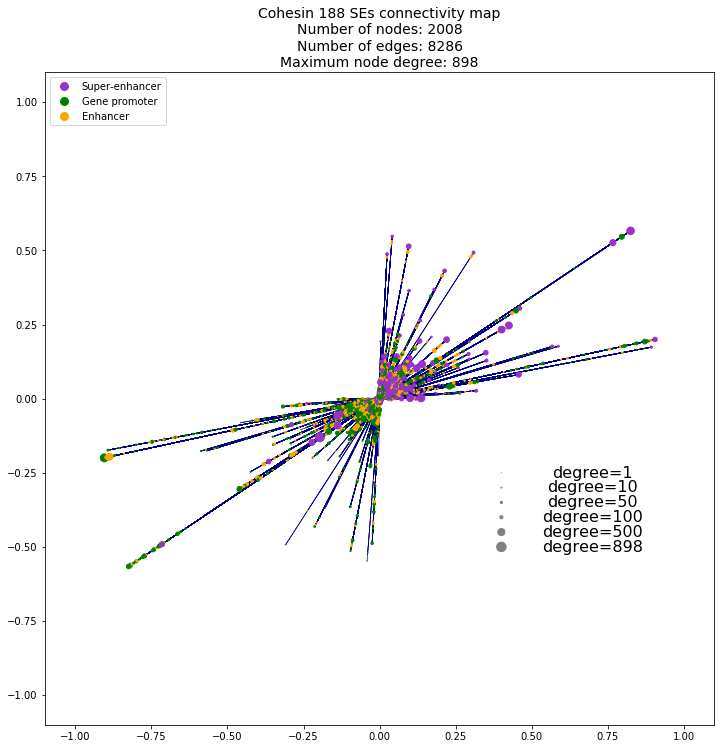

In [60]:
#plt.figure(figsize=(12, 12))
fig, ax = plt.subplots(figsize=(12, 12))
legend_elements = [#Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Super-enhancer', 
                          markerfacecolor='darkorchid', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Gene promoter', 
                          markerfacecolor='green', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Enhancer', 
                          markerfacecolor='orange', markersize=10),
                    #Line2D([0], [0], marker='o', color='w', label='Node Degree=80', 
                    #      markerfacecolor='grey', markersize=80),
                   #Patch(facecolor='orange', edgecolor='r',
                    #     label='Color Patch')
                    ]
nx.draw_networkx_nodes(MG, pos = pos, node_color = ncol, node_size = nsize, ax=ax)
#nx.draw(G, pos, edges=G.edges(), width=10)
pos['ndeg1'] = (0.7, -0.25)
pos['ndeg10'] = (0.7, -0.3)
pos['ndeg50'] = (0.7, -0.35)
pos['ndeg100'] = (0.7, -0.4)
pos['ndeg500'] = (0.7, -0.45)
pos['ndeg898'] = (0.7, -0.5)
nx.draw_networkx_labels(G,pos,labels,font_size=16)
for edge in MG.edges(data=True):
    nx.draw_networkx_edges(MG, pos, edge_color = edge[2]["col"], arrowstyle="-", width = edge[2]["width"], edgelist=[(edge[0],edge[1])])
maxndeg = max(list(nx.get_node_attributes(MG,'ndeg').values()))    
plt.title("Cohesin 188 SEs connectivity map" + "\n" +
          "Number of nodes: " + str(len(MG.nodes())-6) + "\n" 
          + "Number of edges: " + str(len(MG.edges())) + "\n"
          + "Maximum node degree: " + str(maxndeg), fontsize = 14)
plt.ylim((-1.1,1.1))
plt.xlim((-1.1,1.1))
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#plt.legend(loc='upper left')
ax.legend(handles=legend_elements, loc='upper left')
plt.savefig(directory+'GM12878_Cohesin_SE_master_v12.png', dpi=300, bbox_inches='tight')
plt.savefig(directory+'GM12878_Cohesin_SE_master_v12.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [61]:
Counter([x.split("-")[1][0] for x in MG.nodes() if x[0]!="n"])

Counter({'S': 188, 'O': 40, 'E': 902, 'G': 188, 'P': 690})